# Keras TFboy 3D ConvNet

计划步骤

### 预处理

按照 full preprocessing.ipynb 的 resample 方法来做, 

每组 scan 按照 `1mm * 1mm * 1mm`, `1.5mm * 1.5mm * 1.5mm`, `3mm * 3mm * 3mm` 采样

先试 1.5mm, 不行就拿 3mm, 尽量不碰 1mm

完后每个 scan obj 存成 `*.npy`

每个 3dimage 的 shape 是不一样的, 如果是 1.5mm resample, 每个轴大约在 180~280 个数据

需要全补充到一个固定的 shape, 或者裁切掉外侧空气的部分


### Conv Net

按照 first pass through.ipynb 的方式来

但不直接使用 tf, 改用 keras 

网络参数抄 first pass through.ipynb 的

```
X - Conv3D(3,3,3, 32) - RELU - Pool3D
  - Conv3D(3,3,3, 64) - RELU - Pool3D
  - Flatten
  - FC(54080,1024) - RELU - Dropout
  - FC(1024, 2) - Softmax?
```

参数太多, 内存超了, 主要是 Flatten 那一步有巨大数量参数

最后也许不应该用 softmax

In [1]:
%%javascript
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('f5', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('f5', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                                                                        
);

Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-enter', {
    help : 'none',
    // 防止与 Sublime hotkey Ctrl+Enter 冲突
    handler : function (event) {
        return false;
    }}
);

var cell = Jupyter.notebook.get_selected_cell();
var config = cell.config;
var patch = {
      CodeCell: {
        cm_config:{indentUnit: 2}
      }
    }
config.update(patch)


<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
import random
def random_hue(s=100, l=80):
  return 'hsl({}, {}%, {}%)'.format(random.randint(0, 360), s, l)

color1 = random_hue(s=20, l=95)
color2 = random_hue(s=40, l=80)
css = '''
<style>
div.cell {{background-color: {color1};}}
div.running {{background-color: {color2};}}
div.running.selected {{background-color: {color2};}}
</style>'''.format(color1=color1, color2=color2)

display(HTML(css))

In [3]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [4]:
# Some constants 
INPUT_FOLDER = 'D:/Dataset/lung_ct_sample_images/'
patients = os.listdir(INPUT_FOLDER)
if '.DS_Store' in patients:
  patients.remove('.DS_Store')
patients.sort()

print(patients)

['00cba091fa4ad62cc3200a657aeb957e', '0a099f2549429d29b32f349e95fb2244', '0a0c32c9e08cc2ea76a71649de56be6d', '0a38e7597ca26f9374f8ea2770ba870d', '0acbebb8d463b4b9ca88cf38431aac69', '0b20184e0cd497028bdd155d9fb42dc9', '0bd0e3056cbf23a1cb7f0f0b18446068', '0c0de3749d4fe175b7a5098b060982a1', '0c37613214faddf8701ca41e6d43f56e', '0c59313f52304e25d5a7dcf9877633b1', '0c60f4b87afcb3e2dfa65abbbf3ef2f9', '0c98fcb55e3f36d0c2b6507f62f4c5f1', '0c9d8314f9c69840e25febabb1229fa4', '0ca943d821204ceb089510f836a367fd', '0d06d764d3c07572074d468b4cff954f', '0d19f1c627df49eb223771c28548350e', '0d2fcf787026fece4e57be167d079383', '0d941a3ad6c889ac451caf89c46cb92a', '0ddeb08e9c97227853422bd71a2a695e', '0de72529c30fe642bc60dcb75c87f6bd']


## 常用函数

In [5]:
# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s, force=True) for s in os.listdir(path)]
    # InvalidDicomError: File is missing 'DICM' marker. Use force=True to force reading
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices



def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    # value * slope + intercept 之后才是 HU 值
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)
  


def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    # 需要保存计算后的 spacing, 由于 round 原因, 与提供的 spacing 将有微小的差异
    # 单位 毫米
    # 那么resample的方法应该非常重要, 
    # 需要研究 `scipy.ndimage.interpolation.zoom(image, real_resize_factor)` 有没有其他可能的处理方法
    # 重采样非常慢, [0.3,0.3,0.3] 就受不了了
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing


def image_save(image, filename):
  if not filename.endswith('.npy'):
    filename += '.npy'
  np.save(filename, image)
  return filename

def image_load(filename):  
  return np.load(filename)
  

def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    # print(p.shape)
    # print(p)
    verts, faces = measure.marching_cubes(p, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

    
    
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

      
      
def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 # Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image





def normalize(image):
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image
  
  

def zero_center(image):
    PIXEL_MEAN = 0.25
    image = image - PIXEL_MEAN
    return image


  
def threshold_and_normalize(scan):
    scan = scan.astype(np.float32)
    scan [scan < THRESHOLD_LOW] = THRESHOLD_LOW
    scan [scan > THRESHOLD_HIGH] = THRESHOLD_HIGH
    # Maximum absolute value of any pixel .
    max_abs = abs (max(THRESHOLD_LOW, THRESHOLD_HIGH, key=abs))
    # This will bring values between -1 and 1
    scan /= max_abs
    return scan

  
  
def all_files(root, patterns='*', single_level=False, yield_folders=False):
  ''' 取得文件夹下所有文件
  single_level 仅处理 root 中的文件(文件夹) 不处理下层文件夹
  yield_folders 也遍历文件夹'''
  import fnmatch
  patterns = patterns.split(';')
  for path, subdirs, files in os.walk(root):
    if yield_folders:
      files.extend(subdirs)
    files.sort()
    for name in files:
      for pattern in patterns:
        if fnmatch.fnmatch(name, pattern):
          yield os.path.join(path, name)
          break
    if single_level:
      break



def datalines(data, sample=None):
  '''返回一段文字中有效的行(非空行, 且不以注释符号开头)'''
  ret = []
  for l in data.splitlines():
    line = l.strip()
    if line and not line.startswith('#'):
      ret.append(line)
  if sample:
    return ret[:sample]
  else:
    return ret
  
  
  

def load_csv(path, sample=10, only_title=False, include=(), exclude=()):
  from itertools import compress
  import csv

  with open(path) as f:
    titles = f.readline().strip().split(',')

  if include:
    column_compress = [_start_or_end_with(title, include) for title in titles]
  else:
    column_compress = [True] * len(titles)
  if exclude:
    column_compress = [not _start_or_end_with(title, exclude) and tb for title, tb in zip(titles, column_compress)]

  if only_title:
    return list(compress(titles, column_compress))

  with open(path) as f:
    lines = csv.reader(f)
    next(lines)
    result = []
    for i, line in enumerate(lines, 1):
      if sample and i > sample:
        break
      # result.append([_load_csv_value_convert(x) for x in compress(line, column_compress)])
      result.append([x for x in compress(line, column_compress)])

  return result

  
from dicom.errors import InvalidDicomError

def preprocess_scan(prefix, patient_folder, resample_size=(3, 3, 3), output_folder=None):
    # 存储预处理结果
    output_folder = output_folder or prefix
    scan = load_scan(prefix + patient_folder)
    scan_pixels = get_pixels_hu(scan)
    pix_resampled, spacing = resample(scan_pixels, scan, list(resample_size))
    print("Shape before resampling\t", scan_pixels.shape)
    print("Shape after resampling\t", pix_resampled.shape)
    # print(spacing)
    filename = image_save(pix_resampled, output_folder + patient_folder)
    data = {'spacing': [float(n) for n in spacing], 
            'shape': pix_resampled.shape,
            'shape_before_resampled': scan_pixels.shape,
            'resample_size': resample_size,
           }
    yaml_save(data, output_folder + patient_folder)
    print('dump_image done {} \n'.format(patient_folder))

    return filename, pix_resampled.shape, spacing

  
  

def list_sample(a, num=2):
  if num == 0:
    return []
  if num == 1:
    return a[:1]
  step = len(a) / (num-1)
  return [a[int(step*i)] for i in range(0, num-1)] + [a[-1]]

import cv2
def plot_2d_slices(image, label=None, slices=12):
  # image plot 为三行的 slice 图像, 均匀采样
  z, x, y = image.shape
  fig = plt.figure(figsize=(slices*2, 6))
  for plot_index, ix in enumerate(list_sample(list(range(z)), slices)):
    figsub = fig.add_subplot(3, slices, 0 * slices + plot_index + 1)
    each_slice = image[ix, :, :]
    figsub.axis('off')
    figsub.imshow(each_slice)

  for plot_index, ix in enumerate(list_sample(list(range(x)), slices)):
    figsub = fig.add_subplot(3, slices, 1 * slices + plot_index + 1)
    each_slice = image[:, ix, :]
    figsub.axis('off')
    figsub.imshow(each_slice)
    
  for plot_index, ix in enumerate(list_sample(list(range(y)), slices)):
    figsub = fig.add_subplot(3, slices, 2 * slices + plot_index + 1)
    each_slice = image[:, :, ix]
    figsub.axis('off')
    figsub.imshow(each_slice)

  plt.show()


  
  
  
import yaml
from collections import OrderedDict
class IncludeOrderedLoader(yaml.Loader):
  ''' yaml loader
      以有序 dict 替代默认 dict
      值为 !include 开头时, 嵌套另一个 yaml

        -- main.yaml
        key_normal: [foo, bar]
        key_included: !include 'another.yaml'

        -- another.yaml
        foo: bar
        bar: baz

        -- nested result
        key_normal: [foo, bar]
        key_included:
          foo: bar
          bar: baz

      !include 可以是绝对路径或相对路径
      如果嵌套太深, 可能遇到相对路径错乱的问题
  '''
  def __init__(self, stream):
    super(IncludeOrderedLoader, self).__init__(stream)
    self.add_constructor(yaml.resolver.BaseResolver.DEFAULT_MAPPING_TAG,
                         self._construct_mapping)
    self.add_constructor('!include', self._include)
    self._root = os.path.split(stream.name)[0]

  def _include(self, loader, node):
    filename = os.path.join(self._root, self.construct_scalar(node))
    return yaml.load(encode_open(filename), IncludeOrderedLoader)

  def _construct_mapping(self, loader, node):
    loader.flatten_mapping(node)
    return OrderedDict(loader.construct_pairs(node))


def yaml_load(stream, loader=IncludeOrderedLoader):
  ''' 按照有序字典载入yaml 支持 !include
      yaml_load(encode_open(path))
  '''
  return yaml.load(stream, loader)


def yaml_save(data, path):
  if not path.endswith('.yaml'):
    path += '.yaml'
  with open(path, 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

    
    
    
    


def segment_and_normalize(image, verbose=False):
  if verbose:
    print('image')
    a = plt.hist(image.flatten(), bins=50, color='red')
    plt.show()
    # plot_3d(image, -399)
    plot_2d_slices(image)

  image_mask = segment_lung_mask(image, fill_lung_structures=True)
  
  if verbose:
    print('image_mask')
    b = plt.hist(image_mask.flatten(), bins=50, color='orange')
    # plt.show()
    # plot_3d(image_mask, 0)
    plot_2d_slices(image_mask)

  image[image < -400] = -400
  image[image > 600] = 600
  if verbose:
    print('image set limit -400 to 600')
    c = plt.hist(image.flatten(), bins=50, color='yellow')
    plt.show()
    # plot_3d(image, 0)
    plot_2d_slices(image)

  image[image_mask == 0] = -500
  if verbose:
    print('image masked')
    d = plt.hist(image.flatten(), bins=50, color='cyan')
    plt.show()
    # plot_3d(image, 0)
    plot_2d_slices(image)

  MIN_BOUND = -500.0
  MAX_BOUND = 600.0
  image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
  image[image>1] = 1.
  image[image<0] = 0.
  if verbose:
    print('image normed')
    d = plt.hist(image.flatten(), bins=50, color='blue')
    plt.show()
    # plot_3d(image, 0)
    plot_2d_slices(image)
    
  if verbose:
    print('image shape {}, min value {}, max value{}'.format(image.shape, np.min(image), np.max(image)))

  return image







def pad_image_axis(image, value=-1024, axis='z', size=300):
  # shape z, x, y
  shape_index = ({'z': 0, 'x': 1, 'y': 2,}).get(axis)
  old_size = image.shape[shape_index]
  if size == old_size:
    return image
  if size < old_size:
    trim = old_size - size
    trim_before = trim // 2
    trim_after = trim - trim_before
    if axis == 'z': return image[trim_before:-trim_after, :, :]
    if axis == 'x': return image[:, trim_before:-trim_after, :]
    if axis == 'y': return image[:, :, trim_before:-trim_after]

  if size > old_size:
    pad = size - old_size
    pad_before = pad // 2
    pad_after = pad - pad_before
    if axis == 'z': pad_config = ((pad_before, pad_after), (0,0), (0,0))
    if axis == 'x': pad_config = ((0,0), (pad_before, pad_after), (0,0))
    if axis == 'y': pad_config = ((0,0), (0,0), (pad_before, pad_after))
    return np.pad(image, pad_width=pad_config, mode='constant', constant_values=value)


  
def pad_image(image, value=-1024, new_shape=(128, 128, 128)):
  image = pad_image_axis(image, value=value, axis='z', size=new_shape[0])
  image = pad_image_axis(image, value=value, axis='x', size=new_shape[1])
  image = pad_image_axis(image, value=value, axis='y', size=new_shape[2])
  return image
  

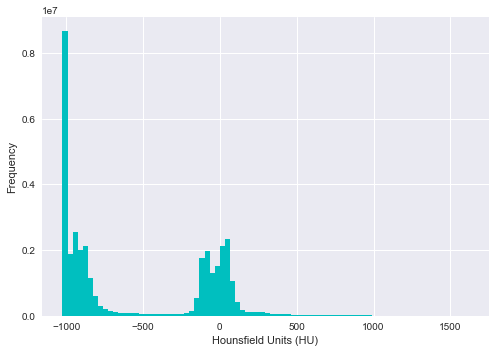

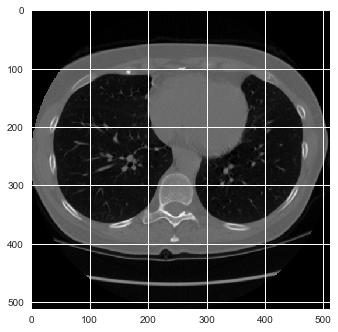

Shape before resampling	 (134, 512, 512)
Shape after resampling	 (223, 204, 204)
[ 1.50224215  1.49999937  1.49999937]


In [16]:
first_patient = load_scan(INPUT_FOLDER + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()


# pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1, 1, 1])
# 1mm*1mm*1mm 之后在 plot_3d 时太慢了, 改粗略些
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1.5, 1.5, 1.5])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

print(spacing)

segmented_lungs


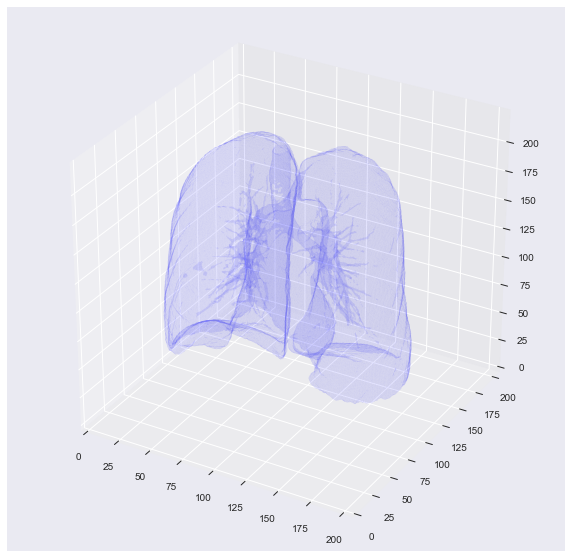

segmented_lungs_fill


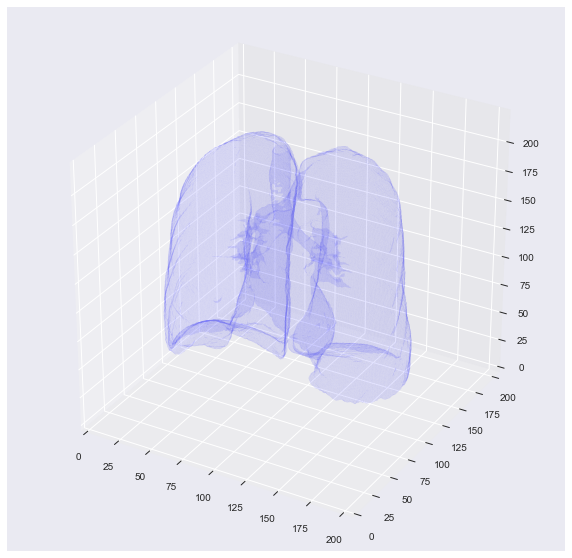

segmented_lungs_fill - segmented_lungs


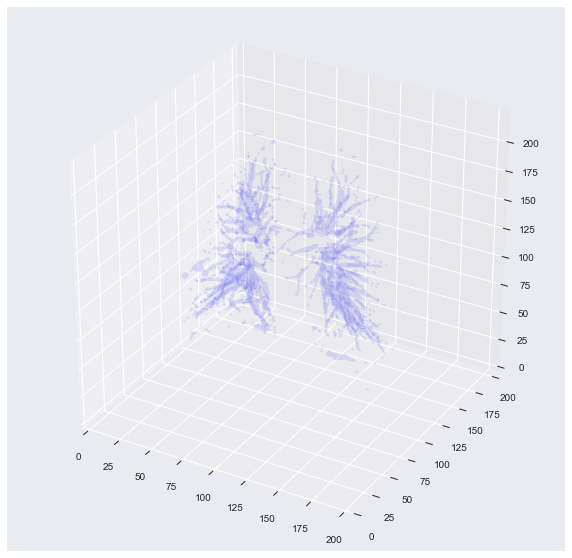

In [18]:
plot_3d(pix_resampled, 400)


segmented_lungs = segment_lung_mask(pix_resampled, fill_lung_structures=False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, fill_lung_structures=True)

print("segmented_lungs")
plot_3d(segmented_lungs, 0)
print("segmented_lungs_fill")
plot_3d(segmented_lungs_fill, 0)
print("segmented_lungs_fill - segmented_lungs")
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

(112, 102, 102)


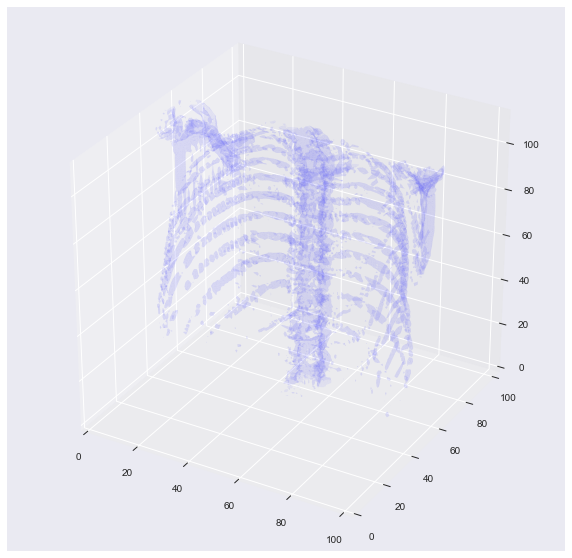

preprocessed_segmented_lungs


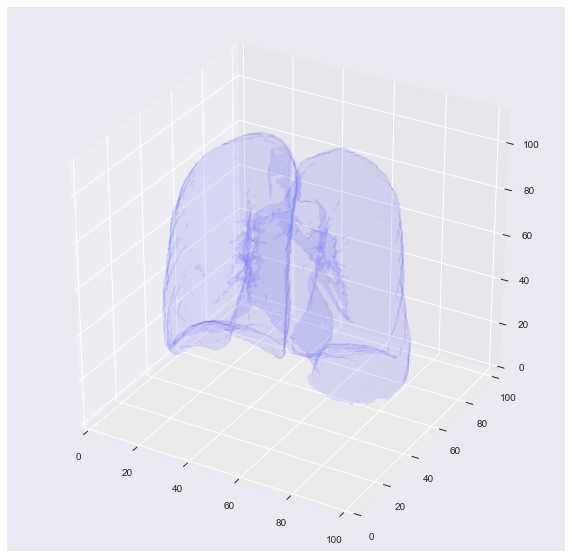

preprocessed_segmented_lungs_fill


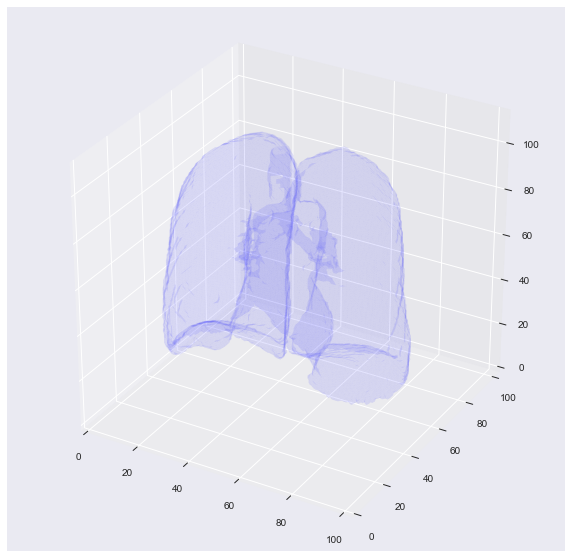

preprocessed_segmented_lungs_fill - preprocessed_segmented_lungs


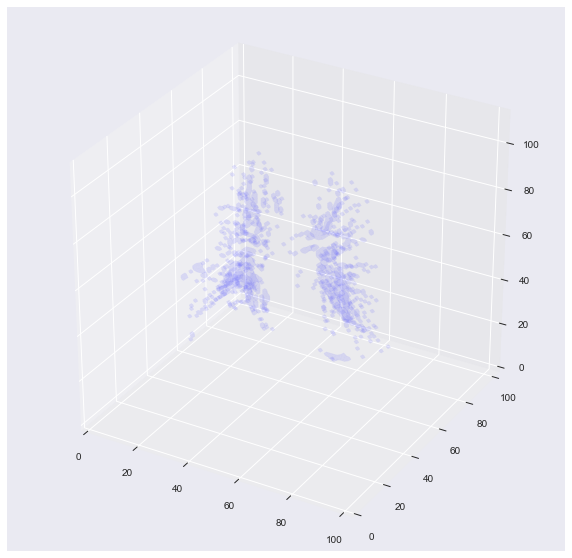

In [24]:
path = 'D:/Dataset/lung_ct_sample_images_preprocessed/'
patient_id = '00cba091fa4ad62cc3200a657aeb957e'
preprocessed = image_load(path + patient_id + '.npy')
print(preprocessed.shape)
plot_3d(preprocessed, 400)

preprocessed_segmented_lungs = segment_lung_mask(preprocessed, fill_lung_structures=False)
preprocessed_segmented_lungs_fill = segment_lung_mask(preprocessed, fill_lung_structures=True)

print("preprocessed_segmented_lungs")
plot_3d(preprocessed_segmented_lungs, 0)
print("preprocessed_segmented_lungs_fill")
plot_3d(preprocessed_segmented_lungs_fill, 0)
print("preprocessed_segmented_lungs_fill - preprocessed_segmented_lungs")
plot_3d(preprocessed_segmented_lungs_fill - preprocessed_segmented_lungs, 0)

image


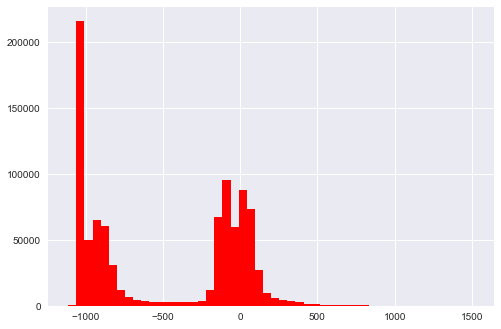

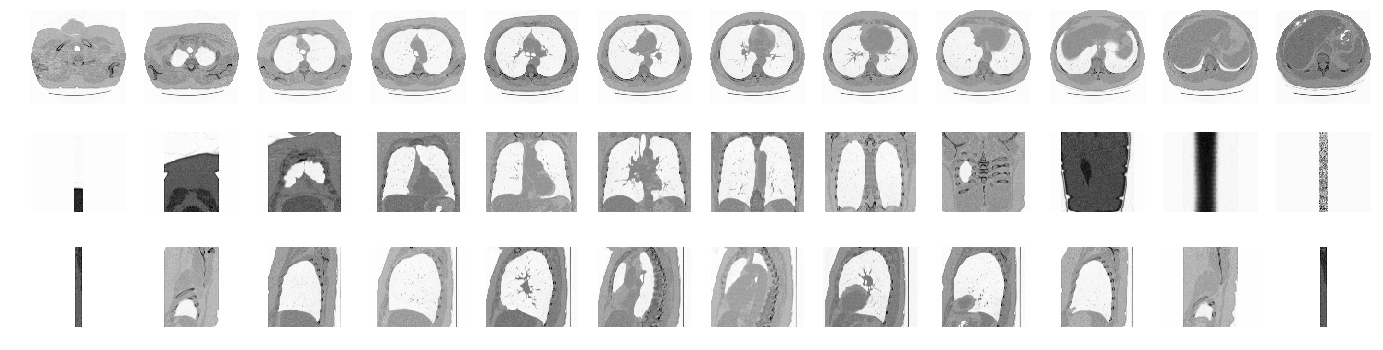

image_mask


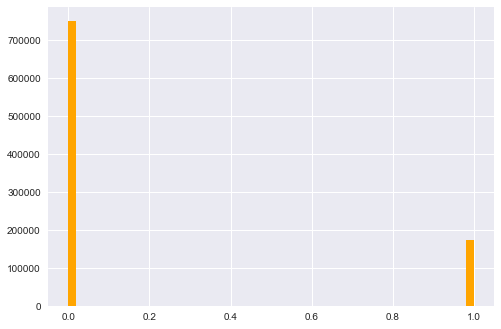

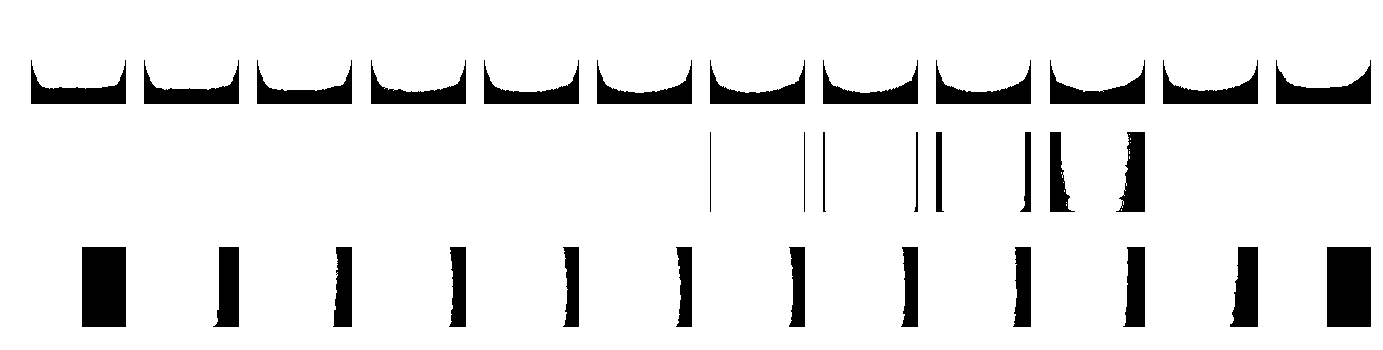

image set limit -400 to 600


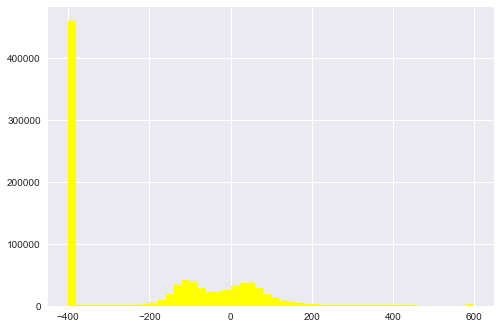

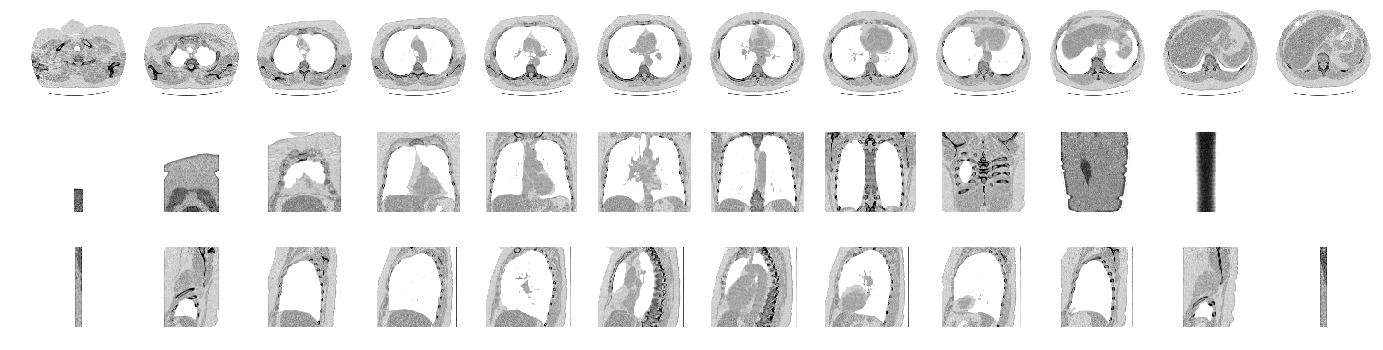

image masked


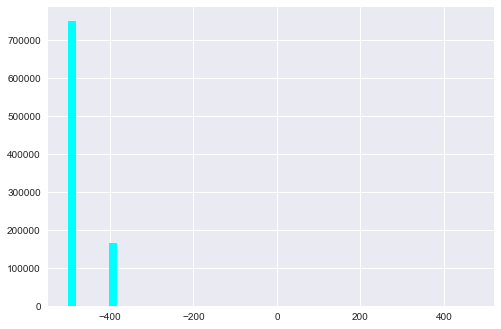

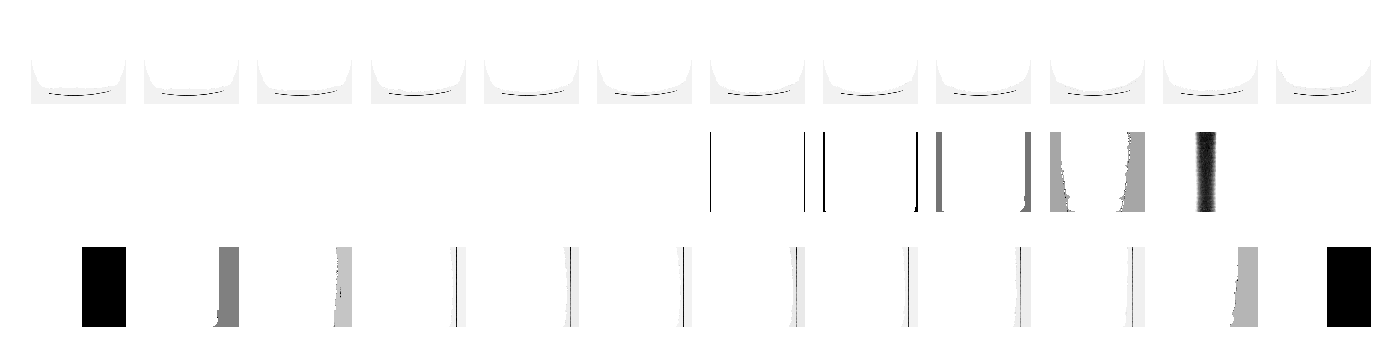

image normed


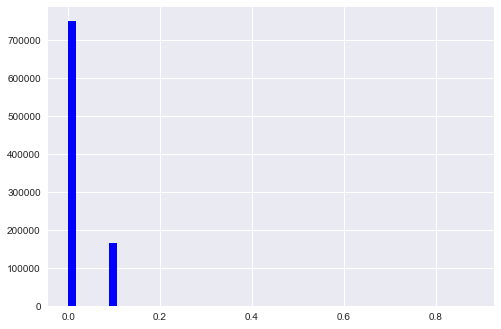

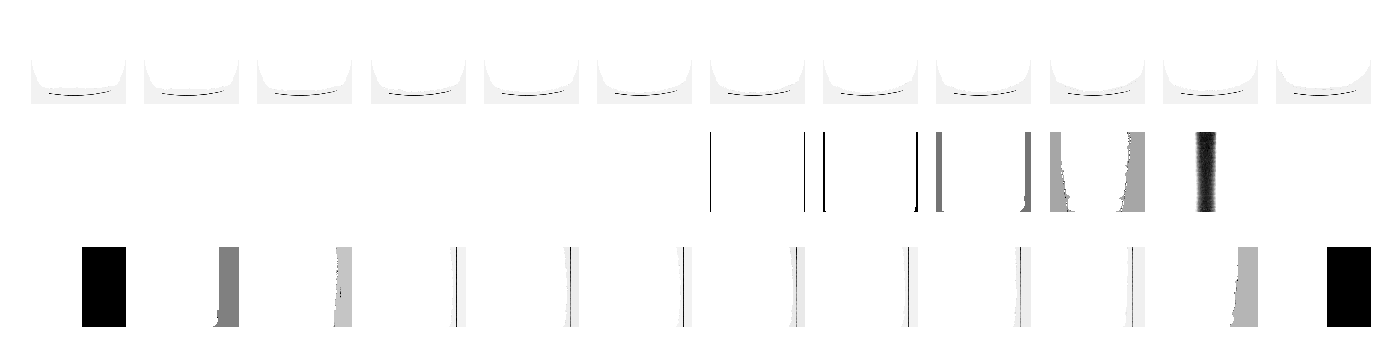

image shape (87, 103, 103), min value 0.0, max value0.8836363636363637


array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.09090909,  0.09090909,  0.09090909, ...,  0.09090909,
          0.09090909,  0.09090909],
        [ 0.09090909,  0.09090909,  0.09090909, ...,  0.09090909,
          0.09090909,  0.09090909],
        [ 0.09090909,  0.09090909,  0.09090909, ...,  0.09090909,
          0.09090909,  0.09090909]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.09090909,  0.09090909,  0.09090909, ...,

In [6]:
path = 'D:/Dataset/lung_ct_sample_images_preprocessed/'
patient_id = '00cba091fa4ad62cc3200a657aeb957e'
patient_id = '1c498f306808952739e7a3a3a2439d1e'  # segment 疑似有误
# 0121c2845f2b7df060945b072b2515d7 0.0
# 026be5d5e652b6a7488669d884ebe297 0.0
# 01de8323fa065a8963533c4a86f2f6c1 0.0
# 0257df465d9e4150adef13303433ff1e 1.0
image = image_load(path + patient_id + '.npy')


segment_and_normalize(image, verbose=True)

In [ ]:

output_filenames, shapes = [], []
for patient_folder in patients:
  try: 
    filename, shape, spacing = preprocess_scan(prefix=INPUT_FOLDER, 
                                               patient_folder=patient_folder)
  except InvalidDicomError as e:
    print(e)
    print("!! InvalidDicomError {}".format(patient_folder))
    continue
      
  output_filenames.append(filename)
  shapes.append(shape)


In [93]:


# plot_2d_slices(pix_resampled, slices=12)
# plot_2d_slices(segmented_lungs, slices=12)
# plot_2d_slices(segmented_lungs_fill, slices=12)

In [ ]:


# plot_2d_slices(pix_resampled, slices=12)
# plot_2d_slices(segmented_lungs, slices=12)
# plot_2d_slices(segmented_lungs_fill, slices=12)

path = '0c0de3749d4fe175b7a5098b060982a1.npy'

image = load_image(path)
# print(image.shape)
plot_2d_slices(image, slices=9)

segmented_lungs = segment_lung_mask(image, fill_lung_structures=False)
plot_2d_slices(segmented_lungs, slices=9)
segmented_lungs_fill = segment_lung_mask(image, fill_lung_structures=True)
plot_2d_slices(segmented_lungs_fill, slices=9)

## Preprocess Stage1

1397


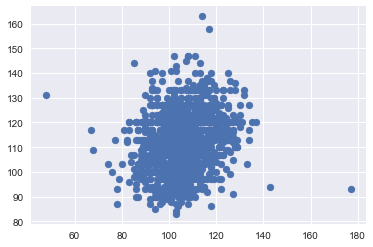

In [13]:
# preview shape

shapes = []

path = 'D:/Dataset/lung_ct_stage1/train_val_preprocessed/'
for path in all_files(path, patterns='*.yaml', single_level=True):
  info = yaml_load(open(path))
  # print(info['shape'])
  shapes.append(info['shape'])  # z, x, y, and x==y
xs = [elem[0] for elem in shapes]
ys = [elem[1] for elem in shapes]

print(len(xs))
plt.scatter(xs, ys)

In [14]:
# pad to same shape

path = 'D:/Dataset/lung_ct_stage1/train_val_preprocessed/024efb7a1e67dc820eb61cbdaa090166.npy'

image = image_load(path)
print('image', image.shape)


  
# image2 = pad_image_axis(image, value=-1025, axis='x', size=400)
# print('image2', image2.shape)
# plot_2d_slices(image, slices=9)
# plot_2d_slices(image2, slices=9)


  
# image2 = pad_image(image, value=1500, new_shape=(128, 128, 128))
# plot_2d_slices(image, slices=9)
# print('image2', image2.shape)
# plot_2d_slices(image2, slices=9)
# print(image2)

image (117, 158, 158)


## Build ConvNet

In [7]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution3D, MaxPooling3D, BatchNormalization
from keras.utils import np_utils
from keras.regularizers import l2

Using TensorFlow backend.


In [20]:
model = Sequential()
L2reg = l2(0.01)
adam = keras.optimizers.Adam(lr=0.001, 
                             beta_1=0.9, beta_2=0.999, 
                             epsilon=1e-08, decay=0.88)

# Convolution3D(nb_filter, kernel_dim1, kernel_dim2, kernel_dim3, 
#               init='glorot_uniform', activation='linear', 
#               weights=None, border_mode='valid', subsample=(1, 1, 1), 
#               dim_ordering='th', W_regularizer=None, b_regularizer=None)

input_shape = (128, 128, 128, 1)

# model.add(MaxPooling3D(input_shape=input_shape))
model.add(Convolution3D(16, 3, 3, 3, 
                        border_mode='same',
                        dim_ordering='tf',
                        # W_regularizer=L2reg,
                        input_shape=input_shape,
                        ))
model.add(Activation('relu'))
model.add(MaxPooling3D())

model.add(Convolution3D(32, 3, 3, 3, 
                        border_mode='same',
                        dim_ordering='tf',
                        ))
model.add(Activation('relu'))
model.add(MaxPooling3D())

model.add(Convolution3D(64, 3, 3, 3, 
                        border_mode='same',
                        dim_ordering='tf',
                        ))
model.add(Activation('relu'))
model.add(MaxPooling3D())

model.add(Flatten())
model.add(Dense(32, W_regularizer=L2reg))
model.add(Activation('relu'))
model.add(Dense(16, W_regularizer=L2reg))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

# model.add(BatchNormalization())

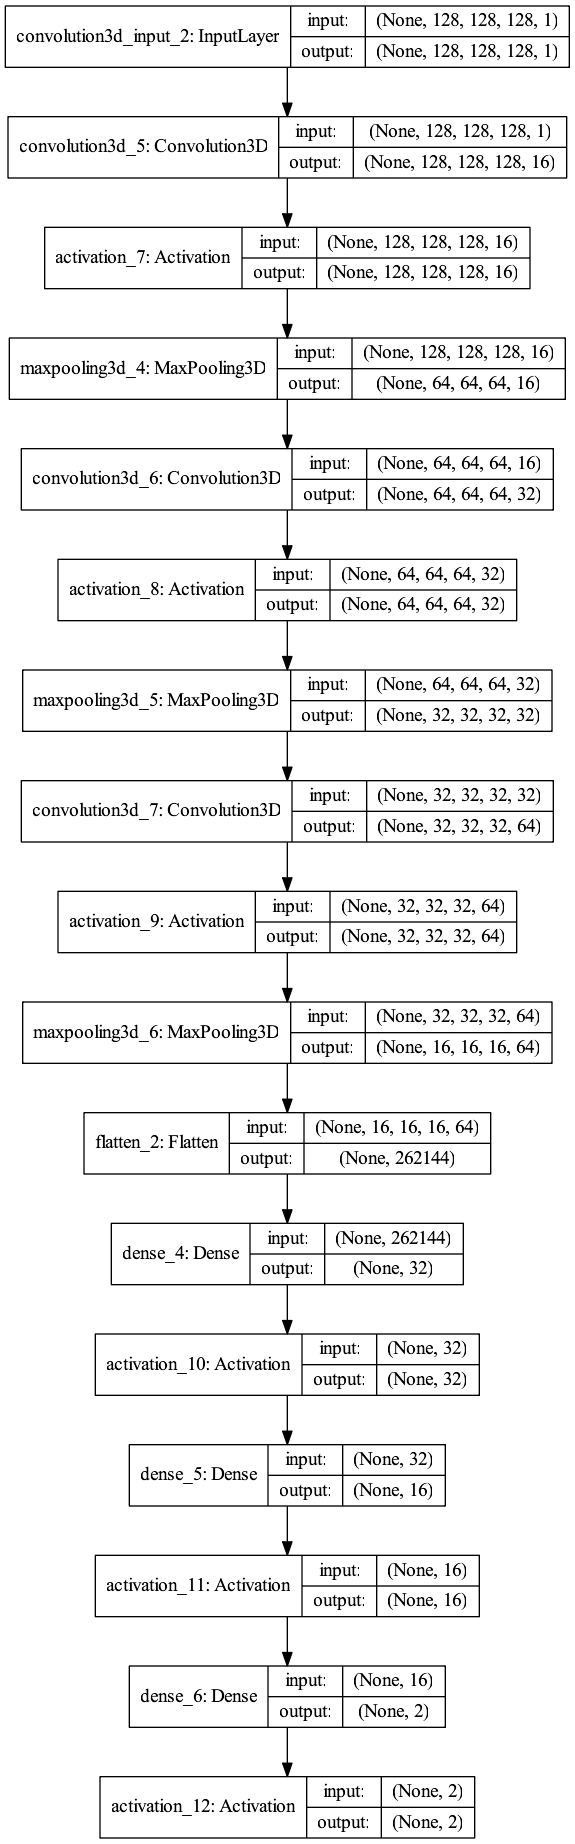

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution3d_5 (Convolution3D)  (None, 128, 128, 128, 448         convolution3d_input_2[0][0]      
____________________________________________________________________________________________________
activation_7 (Activation)        (None, 128, 128, 128, 0           convolution3d_5[0][0]            
____________________________________________________________________________________________________
maxpooling3d_4 (MaxPooling3D)    (None, 64, 64, 64, 16 0           activation_7[0][0]               
____________________________________________________________________________________________________
convolution3d_6 (Convolution3D)  (None, 64, 64, 64, 32 13856       maxpooling3d_4[0][0]             
___________________________________________________________________________________________

In [21]:
from keras.utils.visualize_util import plot
plot(model, show_shapes=True, to_file='model.png')
from IPython.display import display, Image
display(Image('model.png', width=600))

print(model.to_yaml(), file=open('model.yaml', 'w'))
# %pycat model.yaml
print(model.summary())

filepath='model.h5'
# model.save_weights(filepath) # 将模型权重保存到指定路径，文件类型是HDF5（后缀是.h5）
# model.load_weights(filepath, by_name=False)

In [22]:
import platform
windows = platform.platform().startswith('Windows')

class BatchLossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.batch_loss = []
    def on_batch_end(self, batch, logs={}):
        self.batch_loss.append(logs.get('loss'))
batch_loss_history = BatchLossHistory()

In [23]:
adam_for_recompile = keras.optimizers.Adam(lr=0.00001, 
                                           beta_1=0.9, beta_2=0.999, 
                                           epsilon=1e-08, decay=0.88)
# try recompile

# from keras.utils.np_utils import to_categorical
# categorical_labels = to_categorical(int_labels, nb_classes=None)


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])




0015ceb851d7251b8f399e39779d1e7d 1.0
(1, 128, 128, 128, 1)  ----  [[ 0.  1.]]


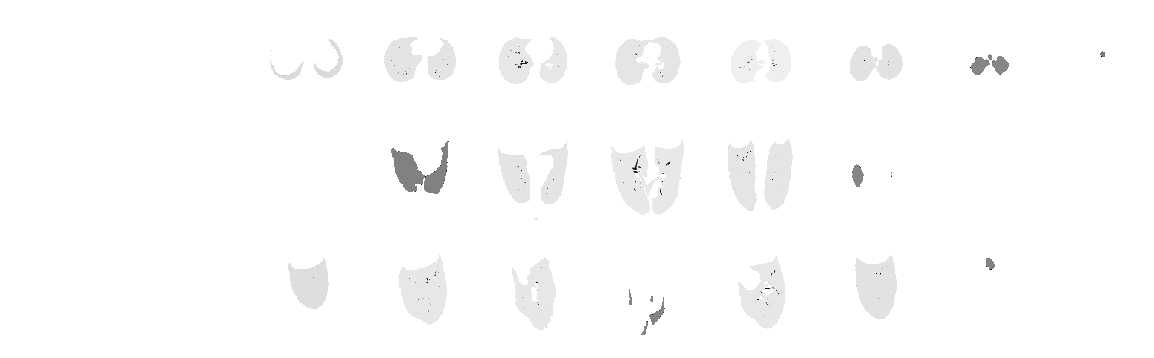


043ed6cb6054cc13804a3dca342fa4d0 0.0
(1, 128, 128, 128, 1)  ----  [[ 1.  0.]]


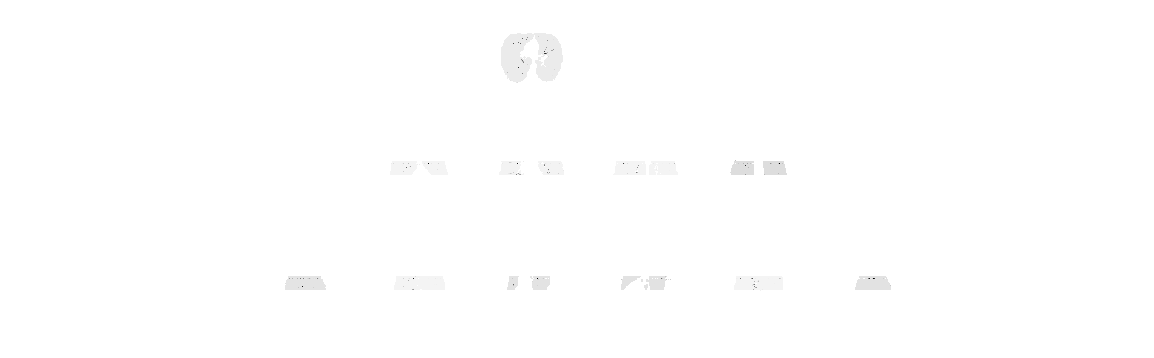


0482c444ac838adc5aa00d1064c976c1 0.0
(1, 128, 128, 128, 1)  ----  [[ 1.  0.]]


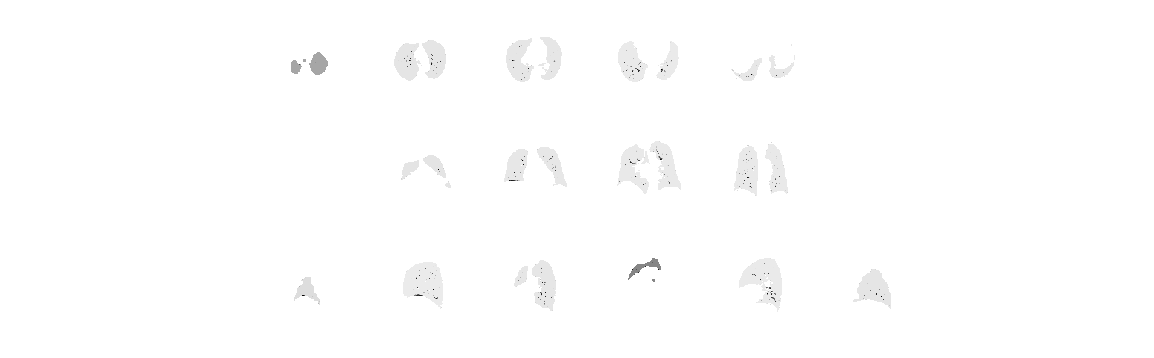


04a3187ec2ed4198a25033071897bffc 0.0
(1, 128, 128, 128, 1)  ----  [[ 1.  0.]]


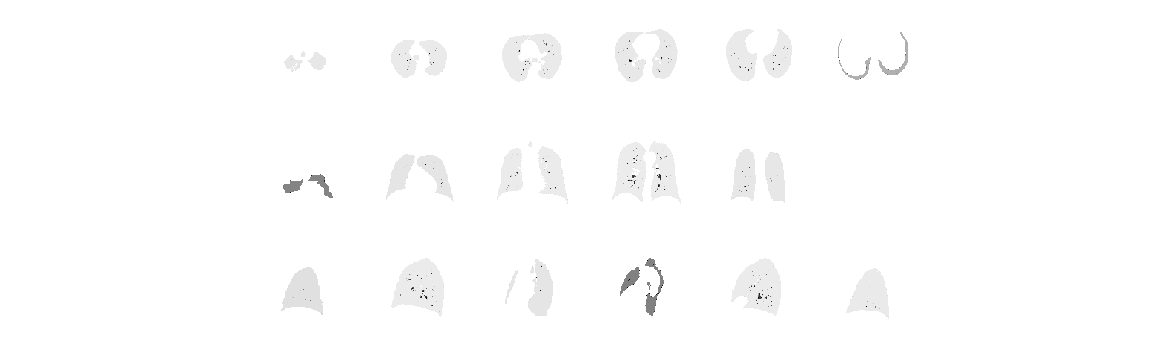

In [16]:
# prepare data

preprocessed_folder = 'D:/Dataset/lung_ct_stage1/train_val_preprocessed/'


import random

def data_generator(folder, batch_size, sample=0, description=None, verbose=False):
  # 按照 keras api, data_generator 应该无限的生成数据, 
  # 由 fit_generator 决定具体使用多少数据

  labels = load_csv('stage1_labels.csv', sample=None)
  labels = {id: float(cancer) for (id, cancer) in labels}
  # print(labels)
  patient_npy_files = all_files(folder, patterns='*.npy', single_level=True, yield_folders=False)
  patient_ids = [path.split('/')[-1][:-4] for path in patient_npy_files]
  if sample > 0:
    # sample > 0 就只取 sample 个数据, 过拟合用
    patient_ids = patient_ids[:sample]
  count = 0
  image_batch = np.zeros((batch_size, 128, 128, 128, 1))
  one_hot_encode_batch = np.zeros((batch_size, 2))
  patient_id_batch = []
  while True:
    patient_id = random.choice(patient_ids)
    patient_label = labels.get(patient_id)
    if verbose:
      print(patient_id, patient_label)
    if patient_label is None: 
      raise ValueError()

    one_hot_encode = (1, 0) if int(patient_label) == 0 else (0, 1)
    image = image_load(folder + patient_id + '.npy')
    # 分割出来肺部, 去掉骨骼等
    image = segment_and_normalize(image, verbose=False)
    # 调整到同样的 shape, 如果数据较大则裁掉外侧部分
    image = pad_image(image, value=0, new_shape=(128, 128, 128))
    # 图像应该有个色彩 channel, 虽然是黑白图 
    image = image.reshape([128, 128, 128, 1])
    # info = yaml_load(open(preprocessed_folder + folder_name + '.yaml'))

    image_batch[count] = image
    one_hot_encode_batch[count] = np.array(one_hot_encode)
    patient_id_batch.append(patient_id)
    count += 1
    if count == batch_size:
      if description:
        print('generating: ', description, ' '.join(pid[:4]+'..' for pid in patient_id_batch))
      yield image_batch, one_hot_encode_batch
      count = 0
      image_batch = np.zeros((batch_size, 128, 128, 128, 1))
      one_hot_encode_batch = np.zeros((batch_size, 2))
      patient_id_batch = []
  
  

def test_gen():
  i = 0
  for image_batch, one_hot_encode_batch in data_generator(preprocessed_folder, 
                                                          batch_size=1,
                                                          sample=30,
                                                          verbose=True):
    # print()
    print(image_batch.shape, ' ---- ', one_hot_encode_batch)
    plot_2d_slices(image_batch[0].reshape((128, 128, 128)), slices=10)
    print()
    i += 1
    if i >= 4:
      break
test_gen()

In [30]:
import platform
windows = platform.platform().startswith('Windows')

preprocessed_folder = 'D:/Dataset/lung_ct_stage1/train_val_preprocessed/'

train_gen = data_generator(preprocessed_folder, batch_size=2, sample=0, description=None)
val_gen = data_generator(preprocessed_folder, batch_size=2, sample=0, description=None)

hist = model.fit_generator(train_gen,
                           samples_per_epoch=1000,
                           nb_epoch=3,
                           validation_data=val_gen,
                           nb_val_samples=100,  # 表示每个 epoch 调用几次 val_gen
                           verbose=2 if windows else 1 , 
                           # callbacks=[batch_loss_history],
                           class_weight=None,
                           )

Epoch 1/3
551s - loss: 0.5784 - acc: 0.7470 - val_loss: 0.5762 - val_acc: 0.7500
Epoch 2/3
543s - loss: 0.6160 - acc: 0.7450 - val_loss: 0.6372 - val_acc: 0.7000
Epoch 3/3
546s - loss: 0.5691 - acc: 0.7860 - val_loss: 0.5509 - val_acc: 0.7600


In [11]:
# model.save_weights('val_acc_0_9.h5')

In [31]:
# test ids

s = '''
  # id,cancer
  026470d51482c93efc18b9803159c960,0.5
  031b7ec4fe96a3b035a8196264a8c8c3,0.5
  03bd22ed5858039af223c04993e9eb22,0.5
  06a90409e4fcea3e634748b967993531,0.5
  07b1defcfae5873ee1f03c90255eb170,0.5
  0b20184e0cd497028bdd155d9fb42dc9,0.5
  12db1ea8336eafaf7f9e3eda2b4e4fef,0.5
  159bc8821a2dc39a1e770cb3559e098d,0.5
  174c5f7c33ca31443208ef873b9477e5,0.5
  1753250dab5fc81bab8280df13309733,0.5
  1cf8e778167d20bf769669b4be96592b,0.5
  1e62be2c3b6430b78ce31a8f023531ac,0.5
  1f6333bc3599f683403d6f0884aefe00,0.5
  1fdbc07019192de4a114e090389c8330,0.5
  2004b3f761c3f5dffb02204f1247b211,0.5
  202898fa97c5949fbdc07ae7ff1cd9f0,0.5
  21b73c938fd7d346ee77a60bd60aaeac,0.5
  243038f7bb7787497c59bc17f04c6ed9,0.5
  26142353f46d20c9fdded93f01e2bff4,0.5
  263a1c3bfa43556623e75ed901e3fd8f,0.5
  2703df8c469906a06a45c0d7ff501199,0.5
  2a3e6ecf9499607ef4fd14b436136b0c,0.5
  2d596b6ead89ab35577fe625a9a17cbb,0.5
  2eb92d17ca91b393765e8acf069763a6,0.5
  2f77fd993fbd858dec3c085b9ff1a3a2,0.5
  3295cec04482210dc6f78c2b4a1d287b,0.5
  33387bea2cacf6127035cc7033036a02,0.5
  34037914ceeec5605fc890159dd425c5,0.5
  38bf066bba822584e14c0af65d4bb5e9,0.5
  3ee1fd6a0f3f108c3558e6699fb011f2,0.5
  42b2161e43b4dd0ea94604485976c59c,0.5
  4434e19303b62ebaecef2596583ff351,0.5
  4575fe61bf3f536ce6cfeb26fcc2893c,0.5
  48ab0b98fc7789304c21430978624f32,0.5
  49433c1588cc078b825a0eff1dc2e816,0.5
  49c88f7cc77341c9ae4e64243f9912fc,0.5
  4b28f147cb82baba3edcdbd34ca19085,0.5
  505405b3e70fb24b92e6a8a5b7ed339c,0.5
  50cdacec399071cf70d8badd2511d0b3,0.5
  519ad4ead3e61d2d71088ac8e46f25b6,0.5
  52f6d741e674f62fbcf73e6ec4f6a472,0.5
  538543b57d0c8fa0b2b6bb7c84df3f33,0.5
  5451203688c930484ba1f3c7f1378847,0.5
  55b06d60e7c0329787f81d1b7cbf9aa0,0.5
  567547810a1795b9c8e11c15dfd32c34,0.5
  5791c42d317f34592be9a933c50e68ad,0.5
  580cffecce8d3d53cde1abb922adf21a,0.5
  59af702c21840ec18073b6b56c95e7fe,0.5
  5a42f0a0d1e060531c20d04ed23efc02,0.5
  5ae9ab473d59cd29262c47a741177b6e,0.5
  5ce91933688cc8400105bf640ac11535,0.5
  5d16819bd78c74448ce852a93bf423ad,0.5
  61017c23bbae6e17062ff582d1a237b3,0.5
  616f98dab4db03edbad28c73d22468d2,0.5
  63458b5875a0b223ec21555d17b52fd4,0.5
  6379e4435f78a5e5c150c32146ece4d4,0.5
  649fd56ef9809019b57261fcf9574d76,0.5
  665c1913d8e90e57af3b745349d19537,0.5
  68f4dff6dd1f135488e83b8a4ee6e20e,0.5
  6993396b31078993e13cf9c0a6fd470b,0.5
  6c71617e2cee498fd3dd20956bb90a3b,0.5
  6d3b16f2e60c3a1a4246f340dba73676,0.5
  6d3be6081d76d2365b080e599628d3bc,0.5
  6d43fdb6eb1bec3a5f4febfd442e8c93,0.5
  6e240f23afa2c1b4352cd0db5d4f357d,0.5
  6f229187fe608c9eacc567eb74c1458c,0.5
  7027c0b8c8f8dcc76c6e4ba923d60a2e,0.5
  70671fa94231eb377e8ac7cba4650dfb,0.5
  70f4eb8201e3155cc3e399f0ff09c5ef,0.5
  7191c236cfcfc68cd21143e3a0faac51,0.5
  763288341ee363a264fe45a28ea28c21,0.5
  7869cc6bfc3678fec1a81e93b34648cf,0.5
  7c2fd0d32df5a2780b4b10fdf2f2cdbe,0.5
  7ce310b8431ace09a91ededcc03f7361,0.5
  7cf1a65bb0f89323668034244a59e725,0.5
  7daeb8ef7307849c715f7f6f3e2dd88e,0.5
  7f096cdfbc2fe03ec7f779278416a78c,0.5
  7fd5be8ec9c236c314f801384bd89c0c,0.5
  80938b4f531fa2334c13d829339e1356,0.5
  80bda1afde73204abd74d1ebd2758382,0.5
  81bd0c062bfa8e85616878bab90f2314,0.5
  82b9fb9e238397b2f3bff98975577ff9,0.5
  83728b6eed98845556bfc870b7567883,0.5
  84ed26b5d79da321711ed869b3cad2ea,0.5
  85ab88f093ca53a4fab5654e24c77ebe,0.5
  85d6fb4a08853d370935a75de7495a27,0.5
  86ad341b9ac27364f03981f6a775246c,0.5
  88acee40bb9d8cb06898d1c5de01d3c8,0.5
  89f003dbfbdbd18a5cdeb9b128cb075b,0.5
  8a1e5830a16db34b580202f8b6dbbd3d,0.5
  8b494d14d835dd5ae13dab19b9520a55,0.5
  8b9a28375988de6ea0b143d48b4a8dc9,0.5
  8bb7dd5fbfa5ecb95552d9c587f2fea5,0.5
  8be7a7cc747365030bee8297221ab5bc,0.5
  8e60f166f1f1dc0d72f997fe1c9e72b4,0.5
  8e9002a485cbda2b47cd14014d6f1c36,0.5
  8f517521a2ed576e853fab1907fa5ffd,0.5
  8fde44df03fb80366c6604db53d3623f,0.5
  901ed0a38aa16933c04ffd531b0aa2cf,0.5
  9050cf3aa8371bd7088c4bdf967141d4,0.5
  9065f2b133129c5747d42db18a424749,0.5
  931253c408c440a8494dfaa74251efd3,0.5
  94df6d1ae21c5bfaebe6f8daf8fcd85b,0.5
  95a98df466d4f6c6689908ea9a8f324b,0.5
  96042e205dd3dc055f084aaca245e550,0.5
  96544665531e7f59bc2730e3c5f42e65,0.5
  96cca9d8e5764daa4bcb6c0ba07735bc,0.5
  993f1e68290d591f755669e97b49b4f4,0.5
  995fc0581ed0e3ba0f97dbd7fe63db59,0.5
  9a378249b799bbcefac2a7de46896c0a,0.5
  9b871732b3935661e7639e84a6ab9747,0.5
  9ca18e68b6b8d9c3112b4b69b7d6fad5,0.5
  9cc74e673ec9807ee055973e1b185624,0.5
  9de48cf43611478ffc1fef051b75dc8c,0.5
  a0e60d7a13f6bb4002cc4a08e60b0776,0.5
  a0fc609febe3eef5a4713a22996cf8e5,0.5
  a2558184e0f4a68e9fb13579d20cb244,0.5
  a2a4bc7708f6831470d757cd6f32bffe,0.5
  a334d15ac8d2d25bce76693b1b2a3ed7,0.5
  a5bb766ab3b1bc5a8023a50a956595f2,0.5
  a5d7909f14d43f01f44cdcaabed27b84,0.5
  a6c15206edadab0270898f03e770d730,0.5
  aa59b7a4aa4dfb2489feea527eda3e4d,0.5
  ab9c7bef62d1ad65b824414087b6f06b,0.5
  ac4056071f3cc98489b9db3aebfe2b6a,0.5
  ae2fdcd8daa3fede6ae23cc63a8d9a82,0.5
  ae4e9d8aab8f8f5ae975bcca923f468d,0.5
  ae61ec94b0b8de5439180f4776551e42,0.5
  aec5a58fea38b77b964007aa6975c049,0.5
  af1d0c2fcde369dd1b715460c2f704a2,0.5
  b0599ad2f33276e7cd065eaa8dcec8a2,0.5
  b17c07114dcf49ce71c8da4b43cf1192,0.5
  b4d5b618fdf3a5a1bcfb325a3715e99e,0.5
  b4db5b96c65a668a2e63f9a3ed36afe7,0.5
  b53d997901eb880c41fbfbc82847204c,0.5
  b6857d98b7b3dbe84f153617f4dfd14b,0.5
  b82efe72526c59a96257208d95e54baf,0.5
  b8793dbd40de88c0de0913abbaab0fe7,0.5
  bbf7a3e138f9353414f2d51f0c363561,0.5
  bdc2daa372a36f6f7c72abdc0b5639d1,0.5
  bdfb2c23a8c1dca5ea8c1cc3d89efee9,0.5
  be3e35bf8395366d235b8bcfc71a05ee,0.5
  be9a2df5a16434e581c6a0625c290591,0.5
  bf6a7a9ab4e18b18f43129c9e22fb448,0.5
  c0c5a155e6e59588783c2964975e7e1e,0.5
  c25876fb40d6f8dafd1ecb243193dd3f,0.5
  c2ef34cc347bc224b5a123426009d027,0.5
  c3a9046fbe2b0f0a4e43a669c321e472,0.5
  c46c3962c10e287f1c1e3af0d309a128,0.5
  c71d0db2086b7e2024ca9c11bd2ca504,0.5
  c7bdb83b7ca6269fac16ab7cff930a2e,0.5
  c87a713d17522698958de55c97654beb,0.5
  c95f2aa23e6d6702f5b16a3b35f89cf0,0.5
  cbb9bbd994c235b56fb77429291edf99,0.5
  cc1b7e34d9eba737c9fb91316463e8f7,0.5
  cc4805e3ebe8621bc94a621b1714fc84,0.5
  cd68d1a14cc504e3f7434d5cc324744d,0.5
  cd6be62834c72756738935f904ec9c2c,0.5
  cdb53f3be6d8cce07fa41c833488d8a5,0.5
  d03127f497cae40bcbd9996b4d1f5b90,0.5
  d032116d73789ff9c805f493357b4037,0.5
  d1131708024b32032ade1ef48d115915,0.5
  d1a20ef45bb03f93a407b492066f6d88,0.5
  d2ec8f0fc56a9168cda0c707e49974ab,0.5
  d3a8fb1da8f7a0dcbd5a8d65f3647757,0.5
  d42c998d037fb3003faba541e2cf649a,0.5
  d4a075768abe7fe43ad1caac92515256,0.5
  d5a0333be8795805fc39509f817780ee,0.5
  d654966fd2498de023552b830c07a659,0.5
  d753676c2c6c8ac6f97bd61ecab7554a,0.5
  d81852bffda09dc8033a45332397c495,0.5
  dbd9c8025907511e965e7abad955547d,0.5
  e0aa61b44c33e6a75940a8541c6894c9,0.5
  e314fd13809db0132443b924401d828b,0.5
  e33c25d0dbca5e54385f2100ce523467,0.5
  e3bc0a970a4af5d52826e06742f90e5b,0.5
  e42065c1145ccf734312cb9edbe5234b,0.5
  e60d99ea9648e1ce859eb0b386365e26,0.5
  e6160ed0ff2eb214abd4df9a3c336c1d,0.5
  e6d8ae8c3b0817df994a1ce3b37a7efb,0.5
  e9a27e2645e1fad9434ce765f678585f,0.5
  ea01deecde93cd9503a049d71d46e6d5,0.5
  ea3a771ef05e288409e0250ea893cf87,0.5
  eaeebb7a63edc8a329a7c5fbc583a507,0.5
  eb9db3f740f8e153e85f83c57bc4e522,0.5
  ebcdfabecf4b46b1e55e4a4c75a0afb0,0.5
  efcb6def7a2080243052b6046186ab24,0.5
  f0310ffc724faf9f7aef2c418127ee68,0.5
  f4d23e0272a2ce5bfc7f07033d4f2e7d,0.5
  f5ff7734997820b45dafa75dff60ece8,0.5
  f7c387290d7e3074501eac167c849000,0.5
  f89e3d0867e27be8e19d7ed50e1eb7e8,0.5
  fad57a1078ddbc685e517bd8f24aa8ac,0.5
  fb55849cee6473974612c17f094a38cd,0.5
  fb5874408966d7c6bebd3d84a5599e20,0.5
  fcfab3eddbdf0421c39f71d651cc5c56,0.5
  fdcd385b0d2d12341661e1abe845be0b,0.5
  ff8599dd7c1139be3bad5a0351ab749a,0.5
'''

test_patient_ids = [line.split(',')[0] for line in datalines(s)]

print(test_patient_ids[:10], len(test_patient_ids))

['026470d51482c93efc18b9803159c960', '031b7ec4fe96a3b035a8196264a8c8c3', '03bd22ed5858039af223c04993e9eb22', '06a90409e4fcea3e634748b967993531', '07b1defcfae5873ee1f03c90255eb170', '0b20184e0cd497028bdd155d9fb42dc9', '12db1ea8336eafaf7f9e3eda2b4e4fef', '159bc8821a2dc39a1e770cb3559e098d', '174c5f7c33ca31443208ef873b9477e5', '1753250dab5fc81bab8280df13309733'] 198


In [32]:

def process_test_image_from_label(folder, patient_id):
  image = image_load(folder + patient_id + '.npy')
  # 分割出来肺部, 去掉骨骼等
  image = segment_and_normalize(image, verbose=False)
  # 调整到同样的 shape, 如果数据较大则裁掉外侧部分
  image = pad_image(image, value=0, new_shape=(128, 128, 128))
  # 图像应该有个色彩 channel, 虽然是黑白图 
  image = image.reshape([128, 128, 128, 1])
  image = image.reshape([1, 128, 128, 128, 1])
  return image



TEST_FOLDER = 'D:/Dataset/lung_ct_stage1/test_preprocessed/'

# test_patient_npy_files = all_files(TEST_FOLDER, patterns='*.npy', 
#                                    single_level=True, yield_folders=False)
# test_patient_ids = [path.split('/')[-1][:-4] for path in test_patient_npy_files]

# print(test_patient_ids)

def predict(method='proba'):
  for test_patient_id in test_patient_ids[:]:
    test_image_batch = process_test_image_from_label(TEST_FOLDER, test_patient_id)
    result = model.predict_classes(test_image_batch, batch_size=1, verbose=0)
    # print(result)
    proba_result = model.predict_proba(test_image_batch, batch_size=1, verbose=0)
    print(test_patient_id,proba_result[0][1])

predict()

026470d51482c93efc18b9803159c960 0.306576
031b7ec4fe96a3b035a8196264a8c8c3 0.623936
03bd22ed5858039af223c04993e9eb22 0.461608
06a90409e4fcea3e634748b967993531 0.761179
07b1defcfae5873ee1f03c90255eb170 0.775694
0b20184e0cd497028bdd155d9fb42dc9 0.301981
12db1ea8336eafaf7f9e3eda2b4e4fef 0.157312
159bc8821a2dc39a1e770cb3559e098d 0.224528
174c5f7c33ca31443208ef873b9477e5 0.122143
1753250dab5fc81bab8280df13309733 0.0978367
1cf8e778167d20bf769669b4be96592b 0.066641
1e62be2c3b6430b78ce31a8f023531ac 0.0618452
1f6333bc3599f683403d6f0884aefe00 0.233192
1fdbc07019192de4a114e090389c8330 0.353865
2004b3f761c3f5dffb02204f1247b211 0.184643
202898fa97c5949fbdc07ae7ff1cd9f0 0.222294
21b73c938fd7d346ee77a60bd60aaeac 0.152365
243038f7bb7787497c59bc17f04c6ed9 0.316436
26142353f46d20c9fdded93f01e2bff4 0.0823205
263a1c3bfa43556623e75ed901e3fd8f 0.259645
2703df8c469906a06a45c0d7ff501199 0.210125
2a3e6ecf9499607ef4fd14b436136b0c 0.107311
2d596b6ead89ab35577fe625a9a17cbb 0.207442
2eb92d17ca91b393765e8acf069763a